In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split as dataSplitter
from sklearn.model_selection import GridSearchCV
from sklearn.base import ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier as skKNN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [2]:
#in future version add roc inside here 
class Algo:
	def __init__(self,trainData,testData):
		self.classifier  = ClassifierMixin()
		self.train(trainData)
		self.test = testData
	@abstractmethod
	def train(self,data):
		pass
	@abstractmethod
	def getName(self,data):
		pass
	def score(self):
		print("test score = "+str(self.classifier.score(self.test.drop(['isPhoton'],axis=1),self.test['isPhoton'])))
	def best_param(self):
		print(self.classifier.best_params_)
	def estimate(self,cluster):
		return self.classifier.predict_proba(cluster)
	def make_roc(self):
		#print(self.estimate(self.test.drop(['isPhoton'],axis=1))[:,1])
		return roc_curve(self.test['isPhoton'],self.estimate(self.test.drop(['isPhoton'],axis=1))[:,1])

In [3]:
class kNN(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(skKNN(),{'n_neighbors':[24,32,38]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "kNN"


In [4]:
class Logistic(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)

	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear',max_iter=1000),{'tol':[1e-4,1e-5,1e-4],'C':[.1,1,10]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "Logistic"

In [5]:
class BDT(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(AdaBoostClassifier(),{'n_estimators':[10000],'learning_rate':[.1,1,.01]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "BDT"

In [6]:
class RandomForest(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(RandomForestClassifier(),{'n_estimators':[500]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "RandomForest"

In [7]:
class MLP(Algo):
	def __intit__(self,trainData,testData):
		trainData, testData = scaler(trainData,testData)
		Algo.__init__(trainData,testData)
		self.name="MLP"
	def scaler(self,train,test):
		_scaler = StandardScaler()
		_scaler.fit_transform(train)
		_scaler.transform(test)
		return train, test
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(MLPClassifier(early_stopping=True),{'alpha':[1e-4],'learning_rate_init':[1e-2],'epsilon':[1e-9],'hidden_layer_sizes':[9,3]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "MLP"

In [8]:
def csvToInput(path):
    df = pd.read_csv(path)
    train, test = dataSplitter(df.values,test_size=.2,shuffle=True)
    train = pd.DataFrame(columns=df.columns,data=train)
    test = pd.DataFrame(columns=df.columns,data=test)
    return train,test

In [9]:
def plotRoc(algos):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure()
    plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y'])))
    lw = len(algos) + 1
    for algo in algos:
        print(algo.getName())
        fpr[algo], tpr[algo],_ = algo.make_roc()
        roc_auc[algo] = auc(fpr[algo],tpr[algo])
        plt.plot(fpr[algo], tpr[algo],
         lw=lw, label=algo.getName()+' (area = %0.2f)' % roc_auc[algo])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [438]:
train, test = csvToInput("photonClusters.csv")
trainS = train
testS = test
train.head()

,Unnamed: 0,isPhoton,total_energy,core_energy,tower0,tower1,tower2,tower3,tower4,tower5,...,tower39,tower40,tower41,tower42,tower43,tower44,tower45,tower46,tower47,tower48
0,22078.0,0.0,1.031903,1.021168,-0.025218,-0.025218,-0.025218,0.009018,0.023115,-0.025218,...,-999.000000,-999.000000,-999.000000,-0.034726,-0.034726,0.061794,0.008172,0.008172,0.469320,-0.034726
1,1611.0,0.0,1.073613,1.028093,-0.024956,-0.024956,0.028689,-0.024956,-0.024956,-0.024956,...,-999.000000,-999.000000,-999.000000,-0.017597,-0.017597,-0.017597,-0.017597,0.028623,-0.017597,-0.017597
2,14227.0,0.0,1.176827,0.966100,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,0.002612,0.176417,-0.049739,-0.049739,-0.049739,-0.049739,0.000518,-0.049739,0.069621,0.188981
3,6169.0,0.0,1.522395,1.449960,-0.025237,0.013073,0.039285,-0.025237,-0.025237,-0.025237,...,0.054127,-0.022970,-0.022970,0.102274,-0.032646,-0.032646,-0.032646,-0.032646,0.020894,-0.032646
4,41794.0,0.0,1.208878,1.268755,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-0.034636,-0.034636,0.059511,0.105539,-0.034636,-0.034636,-0.034636,-0.034636,0.065788,0.107631


In [439]:
def toNA(val):
    if val==-999:
        return np.nan
    else:
        return val

In [440]:
def to0(val):
    if val==-999:
        return 0
    else:
        return val

Try to make some engineered features based off the symmetry of a photon.

In [441]:
def integrated_perimeter(df):
    perimeter_values = [1,2,3,4,5,6,7,13,14,20,21,27,28,34,35,41,42,43,44,45,46,47,48]
    name = 'tower'
    df['integrated_perimeter'] = df['tower0']
    #df.drop(['tower0'])
    for i in perimeter_values:
        title = name+str(i)
        df['integrated_perimeter'] = df['integrated_perimeter']+df[title]
        #df.drop([title])
    return df
        

In [442]:
def max_finder(df):
    perimeter_values = [8,9,10,11,12,15,19,22,26,29,33,36,37,38,39,40]
    name = 'tower'
    df['integrated_perimeter'] = df['tower0']
    #df.drop(['tower0'])
    for i in perimeter_values:
        title = name+str(i)
        df['max_perimeter'] = df['integrated_perimeter']+df[title]
        #df.drop([title])
    return df

In [443]:
def asymmetry(df):
    top = [8,9,10,11,12,15,16,17,18,19]    
    bottom = [29,30,31,32,33,36,37,38,39,40]
    left = [8,9,15,16,22,23,29,30,36,37,43,44]
    right= [11,12,18,19,25,26,32,33,39,40]
    series1 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    series2 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    series3 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    series4 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    name = 'tower'
    for i,j,k,c in zip(top,bottom,left,right):
        title = name+str(i)
        series1 = series1 + df[title]
        title = name+str(j)
        series2 = series2 + df[title]
        title = name+str(k)
        series3 = series3 + df[title]
        title = name+str(c)
        series4 = series4 + df[title]
    df['asymmetry'] = abs(series1-series2) + abs(series3-series4)
    return df

In [444]:
def preprocess(train):
    trainTransformed = pd.DataFrame()
    for column in train:
        trainTransformed  = train[column].apply(to0)
    trainTransformed = integrated_perimeter(train)
    trainTransformed = asymmetry(trainTransformed)
    trainTransformed = max_finder(trainTransformed)
    trainTransformed = trainTransformed.drop(['tower0','tower1','tower2','tower3','tower4','tower5','tower6','tower7','tower8','tower9','tower10','tower11','tower12','tower13','tower14','tower15','tower19','tower20','tower21','tower22','tower26','tower27','tower28','tower29','tower33','tower34','tower35','tower36','tower40','tower41','tower42','tower43','tower44','tower45','tower46','tower47','tower48'],axis=1)    
    df_temp = trainTransformed.drop(['isPhoton','total_energy'],axis=1)
    for column in df_temp:
        df_temp[column] = df_temp[column] / trainTransformed['total_energy']
    trainTransformed = trainTransformed[['isPhoton','total_energy']]
    trainTransformed = pd.concat([trainTransformed,df_temp.drop('Unnamed: 0',axis=1)],axis=1)
    return trainTransformed

In [445]:
train = preprocess(train)
test = preprocess(test)

In [446]:
knn = kNN(train,test)

In [450]:
knn.score()

test score = 0.9548622635247261


In [462]:
knn.best_param()

{'n_neighbors': 32}


logistic  = Logistic(train,test)

logistic.score()

logistic.best_param()

In [458]:
bdt = BDT(train,test)

In [463]:
bdt.score()

test score = 0.9544197366965372


In [461]:
bdt.best_param()

{'learning_rate': 0.1, 'n_estimators': 10000}


In [456]:
randomForest = RandomForest(train,test)

In [ ]:
randomForest.score()

In [ ]:
randomForest.best_param()

In [487]:
diagnoseRandomForest(test.drop(['isPhoton'],axis=1),randomForest.classifier.best_estimator_)

Decision path for DecisionTree 0
Rules used to predict sample 1: 
[   0  954  955 1105 1106 1107 1108 1109 1119 1121 1122 1200 1202 1203
 1217 1357 1358 1362]
Decision path for DecisionTree 1
Rules used to predict sample 1: 
[   0  582  828  829  889  890  891  892  914  915 1027 1028 1044 1058
 1059]
Decision path for DecisionTree 2
Rules used to predict sample 1: 
[  0 576 954 955 956 970 971]
Decision path for DecisionTree 3
Rules used to predict sample 1: 
[  0 462 463 464 465 466 467 468 469 470 471 472 473 477 478]
Decision path for DecisionTree 4
Rules used to predict sample 1: 
[   0  496 1704 1705 1706 1707 1708 1726 1727]
Decision path for DecisionTree 5
Rules used to predict sample 1: 
[  0   1   2 132 134 312 313 314 315 316 320 332 333 334 335 365 366]
Decision path for DecisionTree 6
Rules used to predict sample 1: 
[  0 630 954 955 956 957 958 959 960 961 962 963]
Decision path for DecisionTree 7
Rules used to predict sample 1: 
[   0  584 1016 1908 1909 1910 1982 1988 2

Rules used to predict sample 1: 
[  0   1   2 106 148 149 151 152 170 171 179 180 181 182 183 187]
Decision path for DecisionTree 70
Rules used to predict sample 1: 
[   0  664  914  915 1339 1340 1341 1342 1364 1365 1366 1367 1368 1369
 1399 1407 1408 1409 1411]
Decision path for DecisionTree 71
Rules used to predict sample 1: 
[  0 536 537 538 539 807 808 810 811 815 816 817 821 847 848 849 853]
Decision path for DecisionTree 72
Rules used to predict sample 1: 
[  0   1   2  74  76  86  87  88  90 108 109 110 111 112 113 115 117 119
 120 124]
Decision path for DecisionTree 73
Rules used to predict sample 1: 
[   0 1022 1023 1345 1346 1347 1353 1354 1355 1356 1360]
Decision path for DecisionTree 74
Rules used to predict sample 1: 
[  0   1 331 332 444 572 573 574 575 631 632 684 692 693 694 702 703 739
 740 746 748 749 751 753]
Decision path for DecisionTree 75
Rules used to predict sample 1: 
[   0  576  577 1393 1394 1395 1396 1397 1398 1399 1400 1404 1408 1409
 1417 1419 1420 1421 

Rules used to predict sample 1: 
[   0  662 1010 1174 1175 1176 1177 1181 1182 1318 1319 1341 1345 1381]
Decision path for DecisionTree 146
Rules used to predict sample 1: 
[ 0  1  2  3 11 13 14 30 50 51 52 53 54 62]
Decision path for DecisionTree 147
Rules used to predict sample 1: 
[  0 474 475 476 477 587 588 589 597 598 599 617]
Decision path for DecisionTree 148
Rules used to predict sample 1: 
[   0  562 1480 1481 1482 1514 1590 1756 1757 1758 1760 1762 1763 1764
 1765]
Decision path for DecisionTree 149
Rules used to predict sample 1: 
[   0  666  992  993 1111 1169 1945 1949 2181 2182 2202 2203 2204 2205
 2207 2213 2223 2227 2228 2230]
Decision path for DecisionTree 150
Rules used to predict sample 1: 
[  0   1 349 453 454 508 509 510 524 525 526 527 531 537]
Decision path for DecisionTree 151
Rules used to predict sample 1: 
[   0  652  653  751 1487 1488 1489 1501 1502 1503 1504 1506 1510]
Decision path for DecisionTree 152
Rules used to predict sample 1: 
[  0 216 217 218 21

Rules used to predict sample 1: 
[  0   1   2 296 424 478 479 480 482 483 484 488 490 491 492 493 494 498
 530 682 683 684]
Decision path for DecisionTree 220
Rules used to predict sample 1: 
[   0  654  896 1060 1061 1062 1063 1065 1066 1067 1068 1069 1127 1131
 1132 1136 1137 1141 1142 1143]
Decision path for DecisionTree 221
Rules used to predict sample 1: 
[  0 580 581 582 890 891 892 893 894 895 896 897 901 902]
Decision path for DecisionTree 222
Rules used to predict sample 1: 
[  0   1 317 318 502 546 547 548 554 558 560 576 582 592 618 619 623]
Decision path for DecisionTree 223
Rules used to predict sample 1: 
[  0 286 287 405 406 408 409 410 411 412 416 422 434]
Decision path for DecisionTree 224
Rules used to predict sample 1: 
[   0 1050 1284 2104 2105 2106 2107 2108 2109 2110 2111 2112 2120 2122
 2124 2125 2129 2130 2132 2133 2135 2136]
Decision path for DecisionTree 225
Rules used to predict sample 1: 
[   0 1102 2018 2019 2020 2021 2085 2086 2087 2089 2090 2091 2092 2093

Rules used to predict sample 1: 
[  0 498 499 500 501 619 620 652 653 654 664 672 673 674 675 676 677 683
 691]
Decision path for DecisionTree 297
Rules used to predict sample 1: 
[  0 610 924 925 926 927 928 929 931 932 934 935 936 937 973 977 983 987
 988 990 991 992]
Decision path for DecisionTree 298
Rules used to predict sample 1: 
[  0 632 633 634 635 759 763 764 804 810 811 819 823]
Decision path for DecisionTree 299
Rules used to predict sample 1: 
[   0  644  645  887  888  889  891  911 1123 1124 1125 1126 1127 1137]
Decision path for DecisionTree 300
Rules used to predict sample 1: 
[   0  618  954  955  956  957  958  994  996 1000 1001 1233 1234 1238
 1252 1258 1259 1260 1280 1281 1282 1283 1284]
Decision path for DecisionTree 301
Rules used to predict sample 1: 
[  0 444 445 446 447 448 449 450 451 453 454 455 456 457 458 459 465 467
 473 474]
Decision path for DecisionTree 302
Rules used to predict sample 1: 
[   0  638  982  983  984 1142 1143 1145 1279 1280 1281 1282 1

Rules used to predict sample 1: 
[  0   1 287 288 289 290 291 293 294 295 341 343 344 345 389 390 392 393]
Decision path for DecisionTree 371
Rules used to predict sample 1: 
[   0  538 1774 2102 2234 2254 2256 2257 2259 2260 2261]
Decision path for DecisionTree 372
Rules used to predict sample 1: 
[  0   1   2 288 448 449 450 452 622 623 624 625]
Decision path for DecisionTree 373
Rules used to predict sample 1: 
[  0 616 617 618 708 850 851 852 853 861 863 864 865 867 869 870 874 875]
Decision path for DecisionTree 374
Rules used to predict sample 1: 
[   0  634 1008 1009 1010 1011 1012 1188 1189 1190 1191 1197 1198 1218
 1228 1229 1233 1235 1237]
Decision path for DecisionTree 375
Rules used to predict sample 1: 
[   0  634  635  636 1216 1234 1242 1243 1253 1254 1344 1345]
Decision path for DecisionTree 376
Rules used to predict sample 1: 
[  0   1   2 244 245 246 252 253 254 318 322 323 327 377 393 394 428 429
 430 436 437]
Decision path for DecisionTree 377
Rules used to predict 

Rules used to predict sample 1: 
[   0  524 1732 1733 1734 1735 1736 1737 1917 1919 1921 1925 1926 1927
 1931 1932 1933 1934 1946 1947 1948 1949 1955]
Decision path for DecisionTree 447
Rules used to predict sample 1: 
[  0   1 267 687 841 842 843 844 845 847 848 942 943 944 945 946 947 948
 950 954 955 989]
Decision path for DecisionTree 448
Rules used to predict sample 1: 
[  0   1 659 660 661 747 748 950 951 952 976 980 981 982 983 987 988 992]
Decision path for DecisionTree 449
Rules used to predict sample 1: 
[  0 554 555 556 557 558 559 560 561 563 564]
Decision path for DecisionTree 450
Rules used to predict sample 1: 
[   0  592  593 1209 1210 1211 1212 1213 1214 1215 1216 1218 1219 1220
 1221 1245 1247 1248 1256 1257 1258 1260 1292 1294 1296 1297]
Decision path for DecisionTree 451
Rules used to predict sample 1: 
[   0  692 1036 1037 1185 1191 1243 1244 1245 1246 1266 1296 1297 1299
 1311]
Decision path for DecisionTree 452
Rules used to predict sample 1: 
[   0  630  631  63

In [452]:
mlp = MLP(train,test)

In [ ]:
mlp.score()

In [ ]:
mlp.best_param()

kNN
MLP
RandomForest
BDT


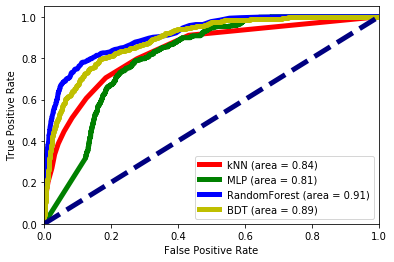

In [459]:
algos = [knn,mlp,randomForest,bdt]
plotRoc(algos)